In [1]:
import pandas as pd
import pylab as plt 
import seaborn as sns
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Function Definition

In [2]:
# The p_value is returned to verify Stationarity
def p_value(df_value):
    result = adfuller(df_value.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [3]:
# Corelation and Differencing Plots (1 e 2).
def Differencing_Plot(df_value):  
    
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    axes[0, 0].plot(df_value)
    axes[0, 0].set_title('Original Series')
    plot_acf(df_value, ax=axes[0, 1])
    
    axes[1, 0].plot(df_value.diff())
    axes[1, 0].set_title('1st Order Differencing')
    plot_acf(df_value.diff().dropna(), ax=axes[1, 1])

    fig.tight_layout()
    return plt.show()

In [4]:
def Model_Creation(parTrain, parMax_p, parMax_q, parSeasonal):
    model = auto_arima(   parTrain,
                          start_p = 0,
                          start_q = 0,
                          information_criterion = 'aic',
                          test = 'adf',
                          max_p = parMax_p,
                          max_q = parMax_q,
                          D = 1,
                          start_P = 0,
                          m = 12,
                          seasonal = parSeasonal,
                          trace = True,
                          error_action = "ignore",
                          suppress_warnings = True,
                          stepwise = True,
                          verbose = 1)
    return model.summary()

In [ ]:
# Dynamic function to divide Dataset into testing and training set 
def Dynamic_Splitting (parDf,parColumn,parTrainSize):
    
    # Test e Train DataSet creation
    train_size = parTrainSize
    Df = parDf
    col = parColumn
    split_idx = round(len(Df[col])* train_size)

    # Split
    train = Df.iloc[:split_idx]
    test = Df.iloc[split_idx:]
    

    # Visualize split
    fig,ax= plt.subplots(figsize=(10,10))
    kws = dict(marker='o')
    plt.plot(train, label='Train', **kws)
    plt.plot(test, label='Test', **kws)
    ax.legend(bbox_to_anchor=[1,1]);
    
    return train, test

In [5]:
# Allows you to perform the study using SARIMAX
# Moreover a what if analysis between test data and prediction is introduced 
# A1: First element for the order of arima
# A2: Second element for the order of arima
# A3: Third element for the order of arima
# S1: First element for Sarima's order
# S2: Second element for Sarima's order
# S3: Third element for the order of Sarima

def Sarimax_Execution(parTrain,parTest,parColumn,parSteps,A1,A2,A3,S1,S2,S3,parSeason):
  
    # Model Built
    model = SARIMAX(parTrain, order=(A1,A2,A3), seasonal_order=(S1,S2,S3,parSeason))
    
    # Fitting model
    results = model.fit()
    
    # Plot parameters
    plt.rcParams['figure.figsize'] = 12, 8
    plot = results.plot_diagnostics()

    # SARIMA - Prevision with Confidence Intervall
    forecast = results.get_forecast(steps = parSteps)
    lower = forecast.conf_int()["lower " + parColumn]
    upper = forecast.conf_int()["upper " + parColumn]
    fig,ax = plt.subplots(1,1,figsize=(20,10))

    plt.plot(parTrain, label='original',c='b')
    plt.plot(forecast.predicted_mean, label='SARIMAX', c="g")
    plt.plot(parTest, label='test',color='orange')
    plt.fill_between(forecast.conf_int().index,lower,upper,color='lightgray')
    plt.xlabel('Date')
    plt.ylabel('No of activated conracts')
    plt.legend()
    plt.show()

    return forecast

# Bergamo Hirings

## Creation of the New DataSet for Time Serie

In [7]:
Hirings = pd.read_csv('Hiring_Computer_Science_Bergamo.csv')

In [8]:
Hirings_Bergamo = Hirings.copy()

In [9]:
Hirings_Bergamo.head(5)

,DATA,SETTOREECONOMICO,ATTIVATO
0,2009-06-09,Tecnologie Informatiche,1
1,2009-06-11,Tecnologie Informatiche,1
2,2009-06-12,Tecnologie Informatiche,1
3,2009-07-02,Tecnologie Informatiche,1
4,2009-07-03,Tecnologie Informatiche,1


## Changing Columns Type

In [10]:
Hirings_Bergamo['DATA'] = pd.to_datetime(Hirings_Bergamo['DATA'])

In [11]:
Hirings_Bergamo.dtypes

DATA                datetime64[ns]
SETTOREECONOMICO            object
ATTIVATO                     int64
dtype: object

In [12]:
Hirings_Bergamo.head()

,DATA,SETTOREECONOMICO,ATTIVATO
0,2009-06-09,Tecnologie Informatiche,1
1,2009-06-11,Tecnologie Informatiche,1
2,2009-06-12,Tecnologie Informatiche,1
3,2009-07-02,Tecnologie Informatiche,1
4,2009-07-03,Tecnologie Informatiche,1


## Rebuilding of the DataSet

In [13]:
Hirings_Bergamo.head()

,DATA,SETTOREECONOMICO,ATTIVATO
0,2009-06-09,Tecnologie Informatiche,1
1,2009-06-11,Tecnologie Informatiche,1
2,2009-06-12,Tecnologie Informatiche,1
3,2009-07-02,Tecnologie Informatiche,1
4,2009-07-03,Tecnologie Informatiche,1


In [14]:
Hirings_Bergamo = Hirings_Bergamo.groupby(pd.Grouper(key='DATA', axis=0, freq='M')).mean(numeric_only = True)

In [15]:
Hirings_Bergamo.head()

,ATTIVATO
DATA,
2009-06-30,1.000000
2009-07-31,1.166667
2009-08-31,1.500000
2009-09-30,3.000000
2009-10-31,2.800000


In [16]:
Hirings_Bergamo.shape

(149, 1)

# Time Series

<AxesSubplot:xlabel='DATA'>

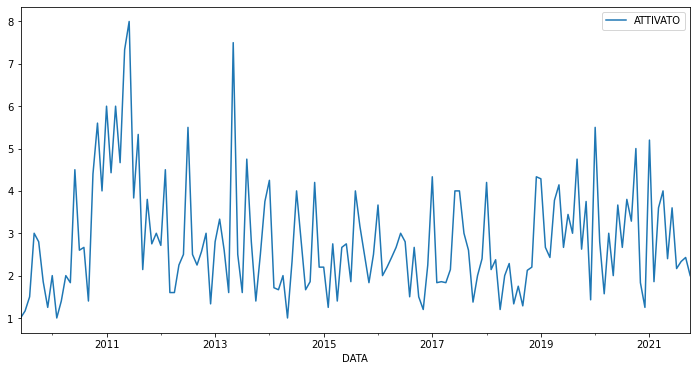

In [17]:
Hirings_Bergamo.plot(figsize=(12,6))

## Seasonality

Seasonality in time-series data refers to a pattern that occurs at a regular interval. 

### Multiplicative Seasonal Decompose

Multiplicative seasonality is not appropriate for zero and negative values

In [ ]:
# Seasonal Variation Analyzing
plt.rcParams.update({'figure.figsize': (8,8)})
result_mult = seasonal_decompose(Hirings_Bergamo['ATTIVATO'], model = 'multiplicative', period = 40)
decomposition_result = result_mult.plot()

### Additive Seasonal Decompose

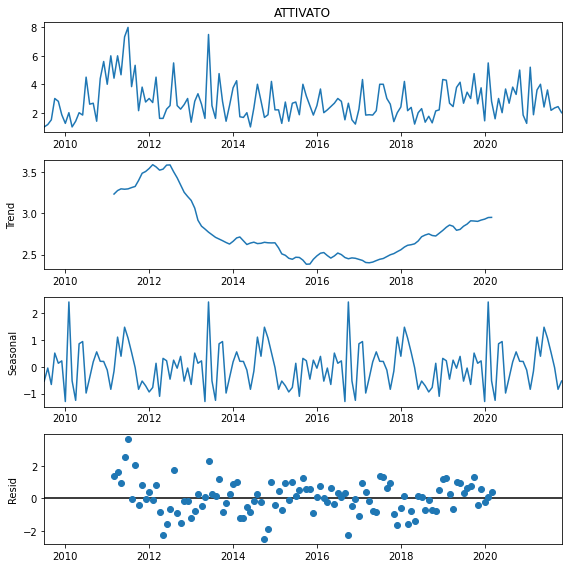

In [18]:
# Seasonal Variation Analyzing
plt.rcParams.update({'figure.figsize': (8,8)})
result_add = seasonal_decompose(Hirings_Bergamo['ATTIVATO'], model = 'additive', period = 40)
decomposition_result = result_add.plot()

## Stationarity

A stationary time series is a series whose statistical properties are independent of the point in time at which they are observed. This Means that Mean, variance and other statistics of a stationary time series remains constant.
The p-value represents a probability of the error when expecting, that the trend differs from zero. Returning p_value to verify Stationarity.

In [19]:
# ADF calculation
p_value(Hirings_Bergamo["ATTIVATO"])

ADF Statistic: -4.713461
p-value: 0.000079


### Differencing

Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) Trend and Seasonality.

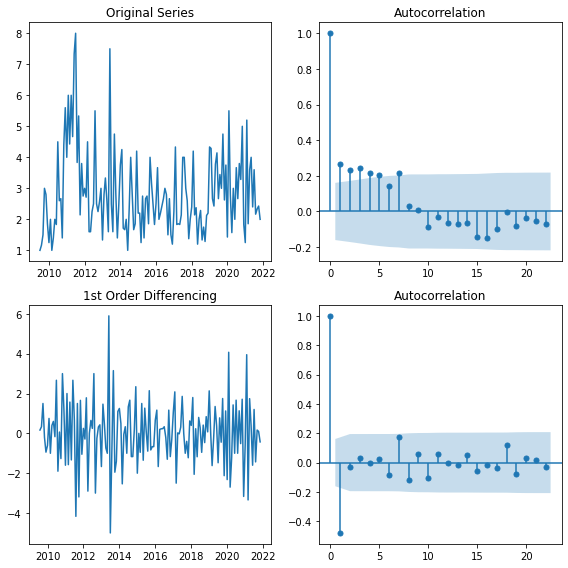

In [20]:
# Differencing plots representation
Differencing_Plot(Hirings_Bergamo["ATTIVATO"])

In [21]:
# Time Serie Stationarity Verification (If p_value < 0.05)
p_value(Hirings_Bergamo["ATTIVATO"].diff())

ADF Statistic: -7.800317
p-value: 0.000000


## Training and Testing Dataset

In this section Training and Testing Dataset are generated with the Dynamic Function "Dynamic_Splitting"

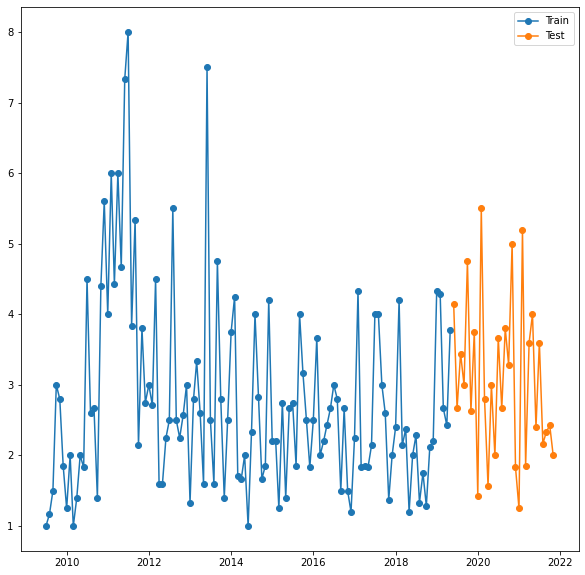

In [23]:
train, test = Dynamic_Splitting(Hirings_Bergamo,"ATTIVATO",0.80)

## SARIMAX Model Implementation

In order to implement the Sarimax prediction model, it's necessary to find out the optimal model. For this reason, the function "Model_Creation" permits to discover the best configuration.

In [24]:
Model_Creation(train,6,6,True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=482.723, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=410.395, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=461.820, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=406.452, Time=0.10 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=398.918, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=399.295, Time=0.26 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=400.102, Time=0.22 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.09 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=419.223, Time=0.10 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=385.789, Time=0.17 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  119
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -186.457
Date:                            Thu, 04 Aug 2022   AIC                            380.914
Time:                                    10:51:34   BIC                            391.567
Sample:                                         0   HQIC                           385.232
                                            - 119                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6864      0.069     -9.966      0.000      -0.821      -0.551
ar.S.L12      -0.2424      0.118     -2.050      0.040      -0.474      -0.011
ma.S.L12      -0.8024      0.220     -3.650      0.000      -1.233      -0.371
sigma2         1.6683      0.320      5.205      0.000       1.040       2.296
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.97
Prob(Q):                              0.91   Prob(JB):                         0.62
Heteroskedasticity (H):               0.37   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Alessandro\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


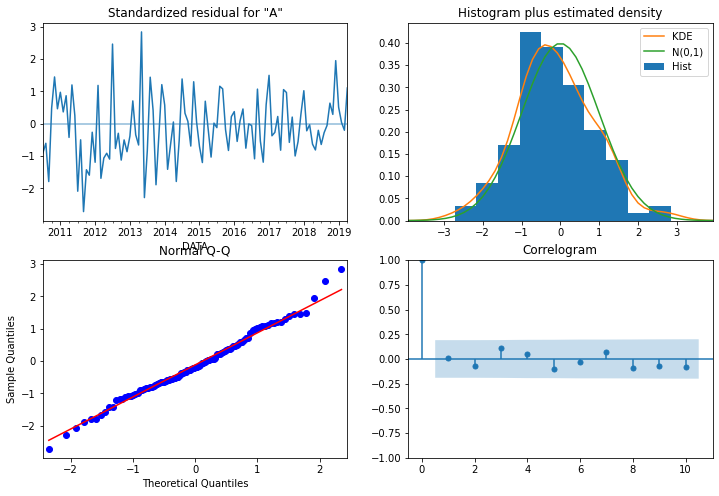

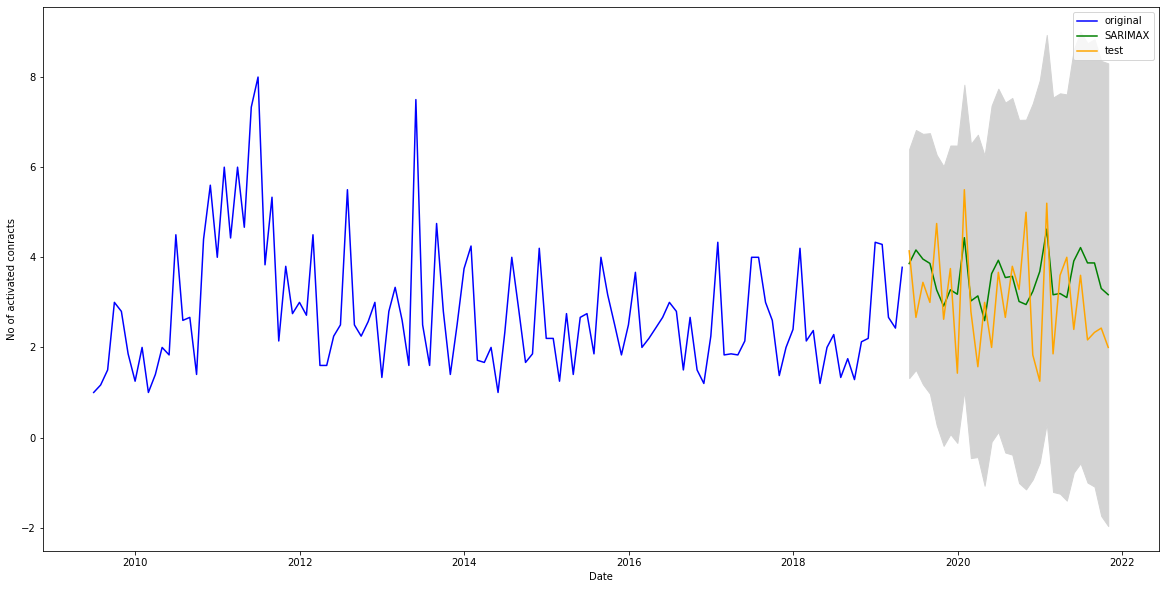

In [25]:
# Numeric values represent:
# First: Number of Test Data
# Middle: the best SARIMAX model returned in the previous Cell
# Last: Periodicity

sarima_prediction = Sarimax_Execution(train,test,"ATTIVATO",30,0,1,1,1,1,1,12)

In [26]:
# Metrics of Sarima Evaluation
rmse = sqrt(mean_squared_error(test,sarima_prediction.predicted_mean))
print('RMSE: %f' % rmse)

RMSE: 1.177510


## LSTM Forecasting

LSTM allows to predict the future values of a Time Serie adopting a Deep Learning approach

Before to start Training and Testing data are scaled. Here the minimum value n the dataset is subtracted of the features, then the elements into the dataset are divided from the Range (Max Value - Min Value) 

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [28]:
Hirings_Bergamo.head(), Hirings_Bergamo.tail()

(            ATTIVATO
 DATA                
 2009-06-30  1.000000
 2009-07-31  1.166667
 2009-08-31  1.500000
 2009-09-30  3.000000
 2009-10-31  2.800000,
             ATTIVATO
 DATA                
 2021-06-30  3.600000
 2021-07-31  2.166667
 2021-08-31  2.333333
 2021-09-30  2.428571
 2021-10-31  2.000000)

In [29]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [30]:
scaled_train[:15]

array([[0.        ],
       [0.02380952],
       [0.07142857],
       [0.28571429],
       [0.25714286],
       [0.12244898],
       [0.03571429],
       [0.14285714],
       [0.        ],
       [0.05714286],
       [0.14285714],
       [0.11904762],
       [0.5       ],
       [0.22857143],
       [0.23809524]])

Elements contained in the 2 datasets are related in proportion to their value.

In [31]:
# Generator Definition for 12 month
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [32]:
X,y = generator[0]
print(f'Array: \n{X.flatten()}')
print(f'Prediction: \n{y}')

Array: 
[0.         0.02380952 0.07142857 0.28571429 0.25714286 0.12244898
 0.03571429 0.14285714 0.         0.05714286 0.14285714 0.11904762]
Prediction: 
[[0.5]]


In [33]:
X.shape  #N_Rows, N_Columns, N_Features

(1, 12, 1)

## LSTM Model Implementation

At this point the LSTM model can be defined. Activation and Loss Functions are required, where the first has 'tanh' as default value, but in this case ReLU function is preferred to guarantee better quality to the neural unit (bounded, monotony, easy to handle)   

In [34]:
# Model Definition
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.fit(generator, epochs = 300)  #Epochs = Number of Iterations

Epoch 1/300
107/107 [==============================] - 1s 3ms/step - loss: 0.0418
Epoch 2/300
107/107 [==============================] - 0s 3ms/step - loss: 0.0423
Epoch 3/300
107/107 [==============================] - 0s 4ms/step - loss: 0.0373
Epoch 4/300
107/107 [==============================] - 0s 3ms/step - loss: 0.0373
Epoch 5/300
107/107 [==============================] - 0s 3ms/step - loss: 0.0372
Epoch 6/300
107/107 [==============================] - 0s 3ms/step - loss: 0.0360
Epoch 7/300
107/107 [==============================] - 0s 3ms/step - loss: 0.0374
Epoch 8/300
107/107 [==============================] - 0s 3ms/step - loss: 0.0348
Epoch 9/300
107/107 [==============================] - 0s 3ms/step - loss: 0.0364
Epoch 10/300
107/107 [==============================] - 0s 3ms/step - loss: 0.0359
Epoch 11/300
107/107 [==============================] - 0s 3ms/step - loss: 0.0356
Epoch 12/300
107/107 [==============================] - 0s 4ms/step - loss: 0.0348
Epoch 13/300


107/107 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 197/300
107/107 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 198/300
107/107 [==============================] - 0s 3ms/step - loss: 0.0082
Epoch 199/300
107/107 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 200/300
107/107 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 201/300
107/107 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 202/300
107/107 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 203/300
107/107 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 204/300
107/107 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 205/300
107/107 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 206/300
107/107 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 207/300
107/107 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 

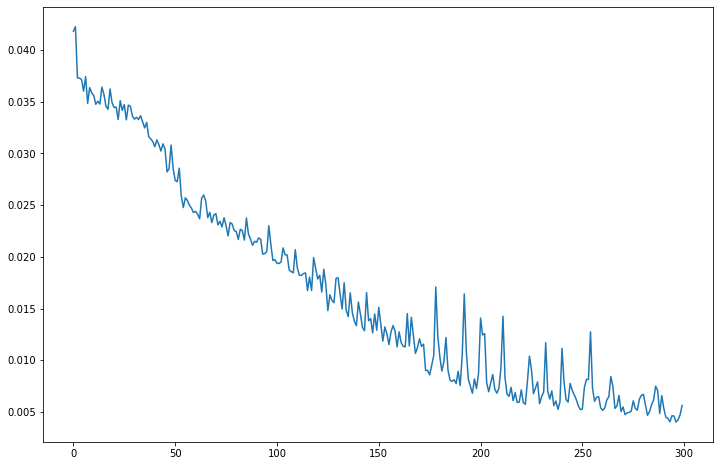

In [37]:
# Plot to analize value loss during epochs
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [38]:
last_train_batch = scaled_train[-12:]

In [39]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [40]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 184ms/step


array([[0.4629556]], dtype=float32)

In [41]:
scaled_test[0]

array([0.44897959])

In [42]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    # Prediction value for First Batch
    current_prediction = model.predict(current_batch)[0] 
    # Append Prediction into the array
    test_predictions.append(current_prediction)          
    # Using Prediction to update batch, removing the first value 
    current_batch = np.append(current_batch[:,1:,:], [[current_prediction]], axis = 1)

1/1 [==============================] - 0s 17ms/step


In [43]:
test_predictions

[array([0.4629556], dtype=float32),
 array([0.509346], dtype=float32),
 array([0.30749092], dtype=float32),
 array([0.38085163], dtype=float32),
 array([0.21461709], dtype=float32),
 array([0.14840452], dtype=float32),
 array([0.18571422], dtype=float32),
 array([0.14424416], dtype=float32),
 array([0.13111265], dtype=float32),
 array([0.24405918], dtype=float32),
 array([0.4553884], dtype=float32),
 array([0.2983708], dtype=float32),
 array([0.2371964], dtype=float32),
 array([0.1362424], dtype=float32),
 array([0.12644884], dtype=float32),
 array([0.336983], dtype=float32),
 array([0.17265001], dtype=float32),
 array([0.12524796], dtype=float32),
 array([0.14319931], dtype=float32),
 array([0.13219906], dtype=float32),
 array([0.20471759], dtype=float32),
 array([0.32627183], dtype=float32),
 array([0.15115495], dtype=float32),
 array([0.12022839], dtype=float32),
 array([0.13092844], dtype=float32),
 array([0.1139916], dtype=float32),
 array([0.15250315], dtype=float32),
 array([0.3

In [44]:
test.head()

,ATTIVATO
DATA,
2019-05-31,4.142857
2019-06-30,2.666667
2019-07-31,3.444444
2019-08-31,3.000000
2019-09-30,4.750000


In [45]:
true_predictions = scaler.inverse_transform(test_predictions)

In [46]:
test['Predictions'] = true_predictions

C:\Users\ALESSA~1\AppData\Local\Temp/ipykernel_11392/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [47]:
test.head()

,ATTIVATO,Predictions
DATA,,
2019-05-31,4.142857,4.240689
2019-06-30,2.666667,4.565422
2019-07-31,3.444444,3.152436
2019-08-31,3.000000,3.665961
2019-09-30,4.750000,2.502320


<AxesSubplot:xlabel='DATA'>

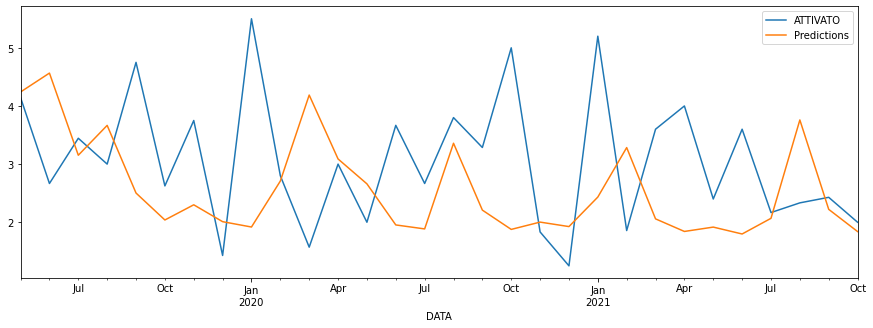

In [48]:
test.plot(figsize = (15,5))

In [49]:
rmse = sqrt(mean_squared_error(test['ATTIVATO'],test['Predictions']))
print(rmse)

1.5228234957977027


# Bergamo Dismissals

## Creation of the New DataSet for Time Serie

In [51]:
Dismissals = pd.read_csv('Dismissal_Computer_Science_Bergamo.csv')

In [52]:
Dismissals_Bergamo = Dismissals.copy()

In [53]:
Dismissals_Bergamo.head(5)

,DATA,SETTOREECONOMICO,CESSATO
0,2009-05-07,Tecnologie Informatiche,2
1,2009-06-12,Tecnologie Informatiche,2
2,2009-07-01,Tecnologie Informatiche,3
3,2009-07-02,Tecnologie Informatiche,1
4,2009-07-03,Tecnologie Informatiche,1


## Changing Columns Type

In [54]:
Dismissals_Bergamo['DATA'] = pd.to_datetime(Dismissals_Bergamo['DATA'])

In [55]:
Dismissals_Bergamo.dtypes

DATA                datetime64[ns]
SETTOREECONOMICO            object
CESSATO                      int64
dtype: object

In [56]:
Dismissals_Bergamo.head()

,DATA,SETTOREECONOMICO,CESSATO
0,2009-05-07,Tecnologie Informatiche,2
1,2009-06-12,Tecnologie Informatiche,2
2,2009-07-01,Tecnologie Informatiche,3
3,2009-07-02,Tecnologie Informatiche,1
4,2009-07-03,Tecnologie Informatiche,1


## Rebuilding of the DataSet

In [57]:
Dismissals_Bergamo.head()

,DATA,SETTOREECONOMICO,CESSATO
0,2009-05-07,Tecnologie Informatiche,2
1,2009-06-12,Tecnologie Informatiche,2
2,2009-07-01,Tecnologie Informatiche,3
3,2009-07-02,Tecnologie Informatiche,1
4,2009-07-03,Tecnologie Informatiche,1


In [58]:
Dismissals_Bergamo = Dismissals_Bergamo.groupby(pd.Grouper(key='DATA', axis=0, freq='M')).mean(numeric_only = True)

In [59]:
Dismissals_Bergamo['CESSATO'] = Dismissals_Bergamo['CESSATO'].ffill()

In [60]:
Dismissals_Bergamo.head()

,CESSATO
DATA,
2009-05-31,2.000000
2009-06-30,2.000000
2009-07-31,1.428571
2009-08-31,2.250000
2009-09-30,2.333333


In [62]:
Dismissals_Bergamo.shape

(150, 1)

# Time Series

<AxesSubplot:xlabel='DATA'>

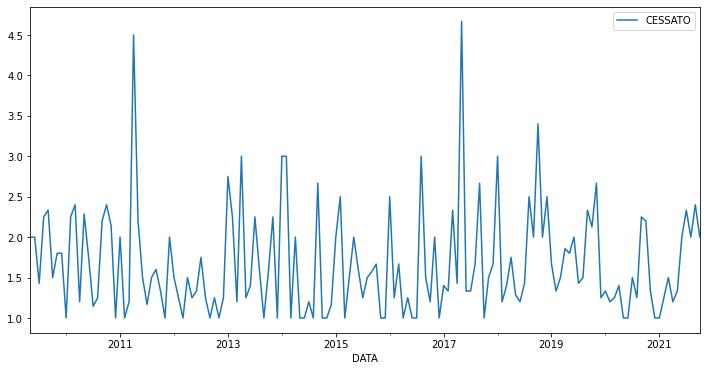

In [63]:
Dismissals_Bergamo.plot(figsize=(12,6))

## Seasonality

Seasonality in time-series data refers to a pattern that occurs at a regular interval. 

### Multiplicative Seasonal Decompose

Multiplicative seasonality is not appropriate for zero and negative values

In [ ]:
# Seasonal Variation Analyzing
plt.rcParams.update({'figure.figsize': (8,8)})
result_mult = seasonal_decompose(Dismissals_Bergamo['CESSATO'], model = 'multiplicative', period = 40)
decomposition_result = result_mult.plot()

### Additive Seasonal Decompose

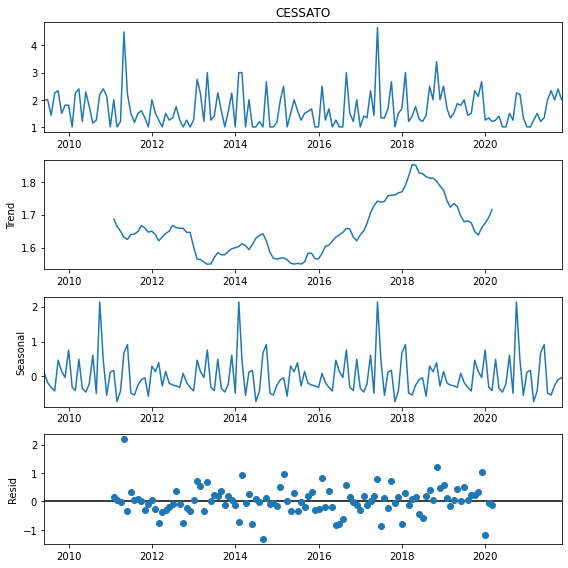

In [64]:
# Seasonal Variation Analyzing
plt.rcParams.update({'figure.figsize': (8,8)})
result_add = seasonal_decompose(Dismissals_Bergamo['CESSATO'], model = 'additive', period = 40)
decomposition_result = result_add.plot()

## Stationarity

A stationary time series is a series whose statistical properties are independent of the point in time at which they are observed. This Means that Mean, variance and other statistics of a stationary time series remains constant.
The p-value represents a probability of the error when expecting, that the trend differs from zero. Returning p_value to verify Stationarity.

In [65]:
# ADF calculation
p_value(Dismissals_Bergamo["CESSATO"])

ADF Statistic: -11.828762
p-value: 0.000000


### Differencing

Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) Trend and Seasonality.

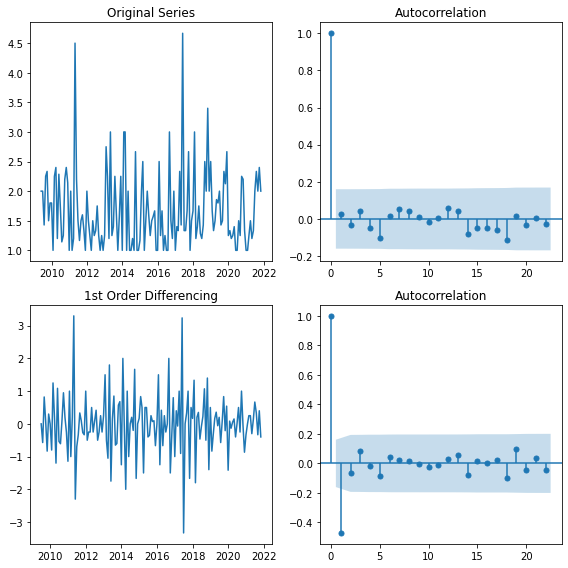

In [66]:
# Differencing plots representation
Differencing_Plot(Dismissals_Bergamo["CESSATO"])

In [67]:
# Time Serie Stationarity Verification (If p_value < 0.05)
p_value(Dismissals_Bergamo["CESSATO"].diff())

ADF Statistic: -8.265723
p-value: 0.000000


## Training and Testing Dataset

In this section Training and Testing Dataset are generated with the Dynamic Function "Dynamic_Splitting"

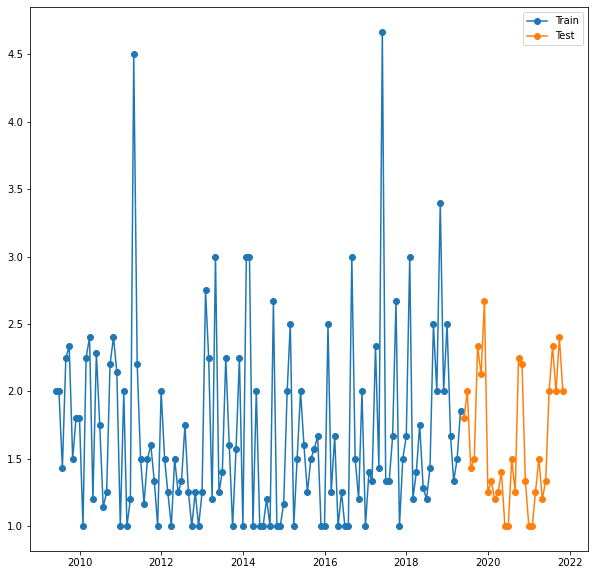

In [69]:
train, test = Dynamic_Splitting(Dismissals_Bergamo,"CESSATO",0.80)

## SARIMAX Model Implementation

In order to implement the Sarimax prediction model, it's necessary to find out the optimal model. For this reason, the function "Model_Creation" permits to discover the best configuration.

In [70]:
Model_Creation(train,6,6,True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=304.621, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=269.104, Time=0.11 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=302.626, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=306.492, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=268.629, Time=0.32 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=266.662, Time=0.26 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=267.264, Time=0.08 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=268.629, Time=0.29 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=270.629, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  120
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood                -129.342
Date:                  Thu, 04 Aug 2022   AIC                            264.683
Time:                          10:53:56   BIC                            272.729
Sample:                               0   HQIC                           267.946
                                  - 120                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.7199      0.096     -7.521      0.000      -0.908      -0.532
ar.S.L24      -0.1900      0.124     -1.531      0.126      -0.433       0.053
sigma2         0.6056      0.064      9.525      0.000       0.481       0.730
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                48.07
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             1.22
Prob(H) (two-sided):                  0.39   Kurtosis:                         5.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Alessandro\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


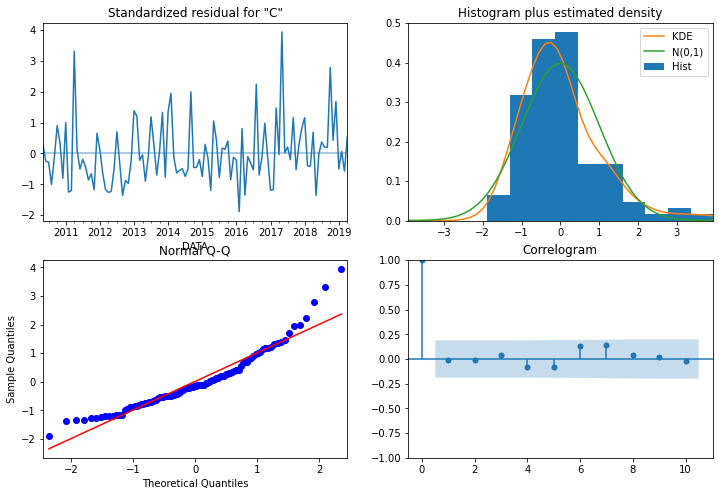

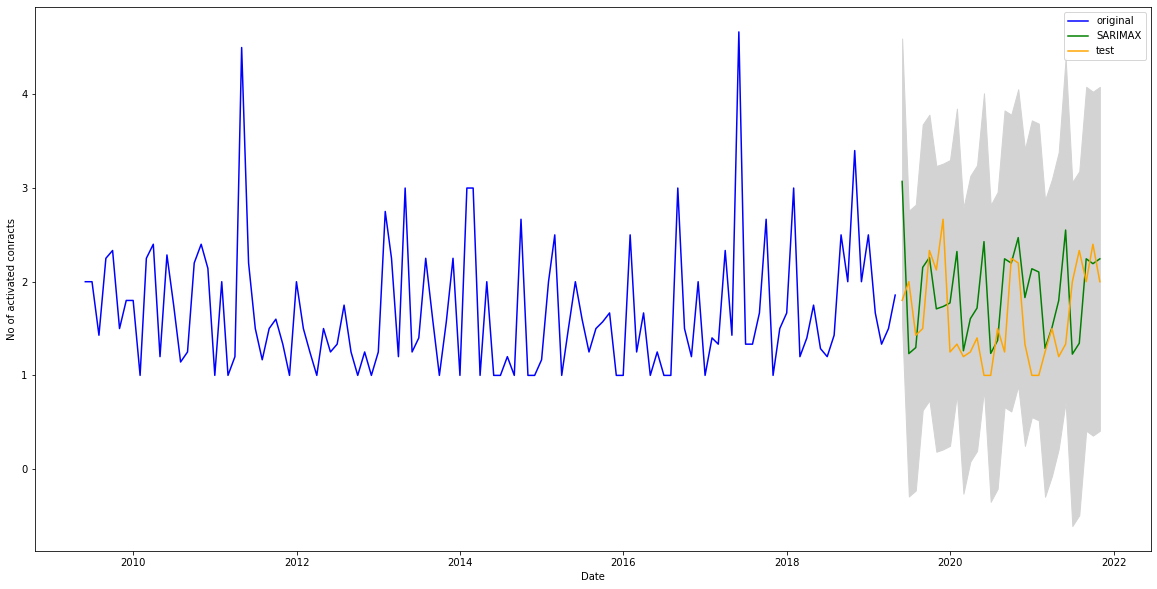

In [71]:
# Numeric values represent:
# First: Number of Test Data
# Middle: the best SARIMAX model returned in the previous Cell
# Last: Periodicity

sarima_prediction = Sarimax_Execution(train,test,"CESSATO",30,0,0,0,2,1,0,12)

In [72]:
# Metrics of Sarima Evaluation
rmse = sqrt(mean_squared_error(test,sarima_prediction.predicted_mean))
print('RMSE: %f' % rmse)

RMSE: 0.699950


## LSTM Forecasting

LSTM allows to predict the future values of a Time Serie adopting a Deep Learning approach

Before to start Training and Testing data are scaled. Here the minimum value n the dataset is subtracted of the features, then the elements into the dataset are divided from the Range (Max Value - Min Value) 

In [73]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [74]:
Dismissals_Bergamo.head(), Dismissals_Bergamo.tail()

(             CESSATO
 DATA                
 2009-05-31  2.000000
 2009-06-30  2.000000
 2009-07-31  1.428571
 2009-08-31  2.250000
 2009-09-30  2.333333,
              CESSATO
 DATA                
 2021-06-30  2.000000
 2021-07-31  2.333333
 2021-08-31  2.000000
 2021-09-30  2.400000
 2021-10-31  2.000000)

In [75]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [76]:
scaled_train[:15]

array([[0.27272727],
       [0.27272727],
       [0.11688312],
       [0.34090909],
       [0.36363636],
       [0.13636364],
       [0.21818182],
       [0.21818182],
       [0.        ],
       [0.34090909],
       [0.38181818],
       [0.05454545],
       [0.35064935],
       [0.20454545],
       [0.03896104]])

Elements contained in the 2 datasets are related in proportion to their value.

In [77]:
# Generator Definition for 12 month
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [78]:
X,y = generator[0]
print(f'Array: \n{X.flatten()}')
print(f'Prediction: \n{y}')

Array: 
[0.27272727 0.27272727 0.11688312 0.34090909 0.36363636 0.13636364
 0.21818182 0.21818182 0.         0.34090909 0.38181818 0.05454545]
Prediction: 
[[0.35064935]]


In [79]:
X.shape  #N_Rows, N_Columns, N_Features

(1, 12, 1)

## LSTM Model Implementation

At this point the LSTM model can be defined. Activation and Loss Functions are required, where the first has 'tanh' as default value, but in this case ReLU function is preferred to guarantee better quality to the neural unit (bounded, monotony, easy to handle)   

In [80]:
# Model Definition
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [81]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [82]:
model.fit(generator, epochs = 300)  #Epochs = Number of Iterations

Epoch 1/300
108/108 [==============================] - 1s 4ms/step - loss: 0.0399
Epoch 2/300
108/108 [==============================] - 0s 4ms/step - loss: 0.0387
Epoch 3/300
108/108 [==============================] - 0s 4ms/step - loss: 0.0388
Epoch 4/300
108/108 [==============================] - 0s 4ms/step - loss: 0.0410
Epoch 5/300
108/108 [==============================] - 0s 3ms/step - loss: 0.0390
Epoch 6/300
108/108 [==============================] - 0s 3ms/step - loss: 0.0376
Epoch 7/300
108/108 [==============================] - 0s 3ms/step - loss: 0.0397
Epoch 8/300
108/108 [==============================] - 0s 4ms/step - loss: 0.0384
Epoch 9/300
108/108 [==============================] - 0s 4ms/step - loss: 0.0388
Epoch 10/300
108/108 [==============================] - 0s 4ms/step - loss: 0.0382
Epoch 11/300
108/108 [==============================] - 0s 4ms/step - loss: 0.0390
Epoch 12/300
108/108 [==============================] - 0s 4ms/step - loss: 0.0377
Epoch 13/300


108/108 [==============================] - 0s 4ms/step - loss: 0.0059
Epoch 197/300
108/108 [==============================] - 0s 4ms/step - loss: 0.0058
Epoch 198/300
108/108 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 199/300
108/108 [==============================] - 0s 4ms/step - loss: 0.0075
Epoch 200/300
108/108 [==============================] - 0s 4ms/step - loss: 0.0068
Epoch 201/300
108/108 [==============================] - 0s 4ms/step - loss: 0.0068
Epoch 202/300
108/108 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 203/300
108/108 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 204/300
108/108 [==============================] - 0s 4ms/step - loss: 0.0062
Epoch 205/300
108/108 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 206/300
108/108 [==============================] - 0s 4ms/step - loss: 0.0068
Epoch 207/300
108/108 [==============================] - 0s 4ms/step - loss: 0.0058
Epoch 

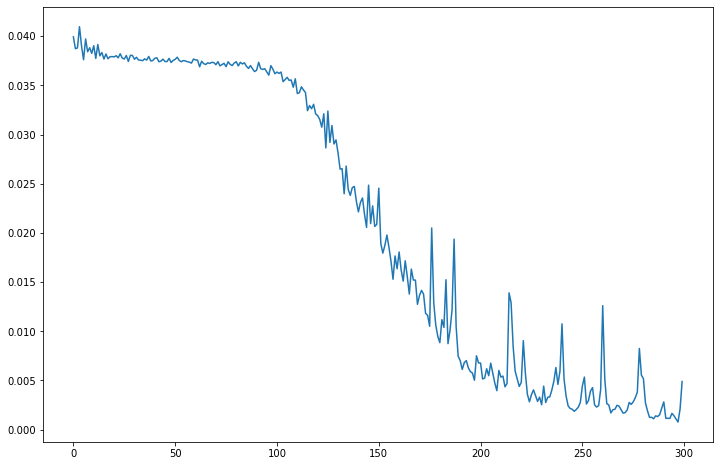

In [83]:
# Plot to analize value loss during epochs
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [84]:
last_train_batch = scaled_train[-12:]

In [85]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [86]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 146ms/step


array([[0.2745705]], dtype=float32)

In [87]:
scaled_test[0]

array([0.21818182])

In [88]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    # Prediction value for First Batch
    current_prediction = model.predict(current_batch)[0] 
    # Append Prediction into the array
    test_predictions.append(current_prediction)          
    # Using Prediction to update batch, removing the first value 
    current_batch = np.append(current_batch[:,1:,:], [[current_prediction]], axis = 1)

1/1 [==============================] - 0s 16ms/step


In [89]:
test_predictions

[array([0.2745705], dtype=float32),
 array([0.10648675], dtype=float32),
 array([0.09151033], dtype=float32),
 array([0.15298879], dtype=float32),
 array([0.1575533], dtype=float32),
 array([0.20443696], dtype=float32),
 array([0.19526218], dtype=float32),
 array([0.06209211], dtype=float32),
 array([0.05031985], dtype=float32),
 array([0.29931933], dtype=float32),
 array([0.1057417], dtype=float32),
 array([0.17966539], dtype=float32),
 array([0.07049997], dtype=float32),
 array([0.01229956], dtype=float32),
 array([0.08280357], dtype=float32),
 array([0.14500579], dtype=float32),
 array([0.16876483], dtype=float32),
 array([0.08351086], dtype=float32),
 array([0.05272247], dtype=float32),
 array([0.02211973], dtype=float32),
 array([-0.01509998], dtype=float32),
 array([0.07983592], dtype=float32),
 array([0.27425632], dtype=float32),
 array([0.28468767], dtype=float32),
 array([0.092995], dtype=float32),
 array([0.40083316], dtype=float32),
 array([0.23183392], dtype=float32),
 arra

In [90]:
test.head()

,CESSATO
DATA,
2019-05-31,1.800000
2019-06-30,2.000000
2019-07-31,1.428571
2019-08-31,1.500000
2019-09-30,2.333333


In [91]:
true_predictions = scaler.inverse_transform(test_predictions)

In [92]:
test['Predictions'] = true_predictions

C:\Users\ALESSA~1\AppData\Local\Temp/ipykernel_11392/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [93]:
test.head()

,CESSATO,Predictions
DATA,,
2019-05-31,1.800000,2.006758
2019-06-30,2.000000,1.390451
2019-07-31,1.428571,1.335538
2019-08-31,1.500000,1.560959
2019-09-30,2.333333,1.577695


<AxesSubplot:xlabel='DATA'>

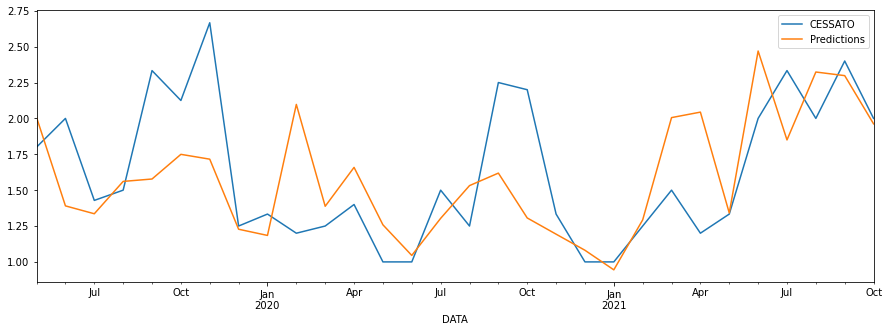

In [94]:
test.plot(figsize = (15,5))

In [95]:
rmse = sqrt(mean_squared_error(test['CESSATO'],test['Predictions']))
print(rmse)

0.44384729911612697
